<a href="https://colab.research.google.com/github/keizikang/self_study_mldl/blob/main/%ED%98%BC%EA%B3%B5%EB%A8%B8%EC%8B%A0_8%EC%9E%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

# 8. 이미지를 위한 인공 신경망: 럭키백의 정확도를 높여라!

---


---

## 8.2 합성곱 신경망(CNN)을 사용한 이미지 분류

---

CNN은 쉽게 말해 이미지에 필터를 입히고 크기를 줄인 걸로 학습하겠다는 것임

전체 구조: 합성곱 - 풀링 - 합성곱 - 풀링 - 밀집층

* 합성곱
  - 합성곱은 convolution을 생각하면 됨
  - 이미지를 필터링 하는 개념이므로 Flatten을 하지 않음
  - 필터는 보통 3x3, 종류는 다양함 (사실 알아서 정해줌)
  - 합성곱 연산 시 이미지 크기를 유지하고 각 픽셀의 기여도 편차를 줄이기 위해 zero padding이 필요함 

* 풀링
  - 풀링은 합성곱 결과의 크기를 줄이는 과정
  - 전체를 두부 썰듯이 조각내고 (각 조각은 2x2 이상) 조각마다 값을 하나만 뽑음
  - 하나를 뽑는 기준은 최대값을 뽑는 최대 풀링, 평균값을 뽑는 평균 풀링이 있음

* 밀집층
  - 일반적인 DNN을 생각하면 됨
  - 여기서는 Flatten이 필요함

tf에서는 zero padding, 필터링(convolution), 풀링 등은 알아서 해줌

각 층을 만들 때 파라미터로 설정만 해주면 됨

---


In [2]:
# 패션 MNIST 불러오고 훈련/검증/테스트 세트 나눔
# CNN은 Flatten이 필요하지 않음

from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) = \
    keras.datasets.fashion_mnist.load_data()
# train_input.shape = (60000, 28, 28)
# train_target.shape = (60000,)
# test_input.shape = (10000, 28, 28)
# test_target.shape = (10000,)

train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0
# train_scaled.shape = (60000, 28, 28, 1)

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)
# train_scaled.shape = (48000, 28, 28, 1)
# train_target.shape = (48000,)
# val_scaled.shape = (12000, 28, 28, 1)
# val_target.shape = (12000,)

4431872/4422102 [==============================] - 0s 0us/step


In [3]:
# 합성곱 신경망 만들기
model = keras.Sequential() # 빈 신경망

# 합성곱층 추가
model.add(keras.layers.Conv2D(32, # 첫 번째 인자는 필터 개수
                              kernel_size=3, 
                              activation='relu', 
                              padding='same',
                              input_shape=(28, 28, 1)))
# output_shape = (28, 28, 32)

# 풀링층 추가
model.add(keras.layers.MaxPooling2D(2)) # 풀링 크기 = (2, 2)
# output_shape = (14, 14, 32)

# 두 번째 합성곱층 추가
model.add(keras.layers.Conv2D(64, # 필터 개수
                              kernel_size=3, 
                              activation='relu',
                              padding='same'))
# output_shape = (14, 14, 64)

# 두 번째 풀링층 추가
model.add(keras.layers.MaxPooling2D(2))
# output_shape = (7, 7, 64)

In [4]:
# 밀집층에 넣기 전에는 Flatten 해줘야 함
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               3

---

첫 번째 합성곱층
* 필터 당 파라미터 개수 = 3 x 3 + 1(절편) = 10
* 전체 파라미터 개수 = (필터 개수)x(필터 당 파라미터 개수) = 320

두 번째 합성곱층
* 필터 당 파라미터 개수 = 3 x 3 x 32 + 1 = 289
* 전체 파라미터 개수 = 64 x 289 = 18496

밀집층
* 입력 노드 개수 = 7 x 7 x 64 = 3136개
* 은닉층 노드 개수 = 100
* 파라미터 개수 = 3136 x 100 + 100 = 313700

---

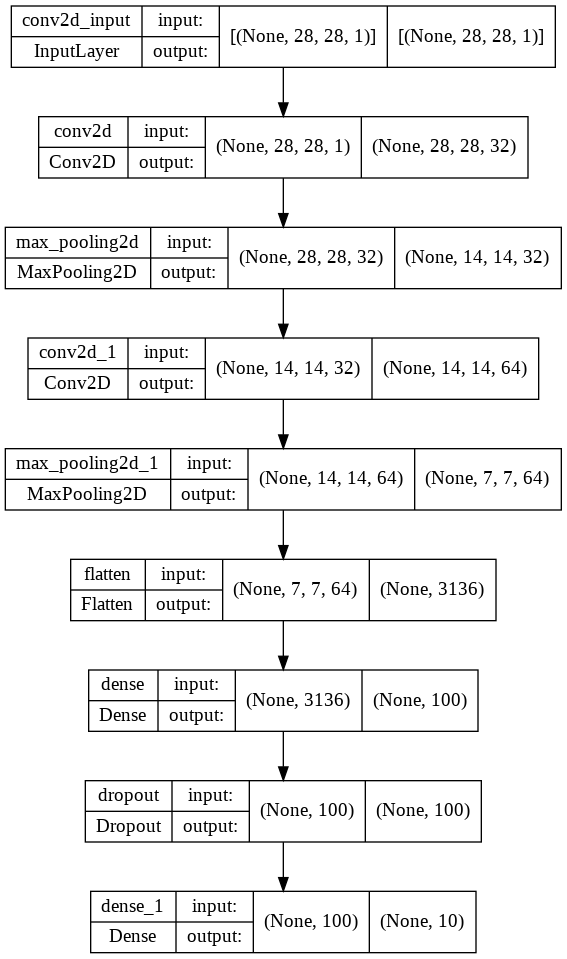

In [5]:
# 전체 구조를 순서도처럼 보기
keras.utils.plot_model(model, show_shapes=True)

In [6]:
# 컴파일: 옵티마이저, 손실함수, 저장할 메트릭 설정
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics='accuracy')

# 췍포인트: 에포크마다 모델을 저장, 손실이 가장 작은 것만 남김
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5',
                                                save_best_only=True)

# 얼리스톱핑: 2번 이상 손실이 감소하지 않으면 멈추고 최적 파라미터 상태로 되돌림
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

history = model.fit(train_scaled, train_target, 
                   epochs=20,
                   validation_data=(val_scaled, val_target),
                   callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 90s 59ms/step - loss: 0.5285 - accuracy: 0.8109 - val_loss: 0.3281 - val_accuracy: 0.8776
Epoch 2/20
1500/1500 [==============================] - 87s 58ms/step - loss: 0.3518 - accuracy: 0.8749 - val_loss: 0.2892 - val_accuracy: 0.8936
Epoch 3/20
1500/1500 [==============================] - 76s 51ms/step - loss: 0.2994 - accuracy: 0.8924 - val_loss: 0.2554 - val_accuracy: 0.9043
Epoch 4/20
1500/1500 [==============================] - 91s 61ms/step - loss: 0.2699 - accuracy: 0.9031 - val_loss: 0.2461 - val_accuracy: 0.9060
Epoch 5/20
1500/1500 [==============================] - 80s 53ms/step - loss: 0.2418 - accuracy: 0.9112 - val_loss: 0.2321 - val_accuracy: 0.9148
Epoch 6/20
1500/1500 [==============================] - 81s 54ms/step - loss: 0.2250 - accuracy: 0.9161 - val_loss: 0.2208 - val_accuracy: 0.9197
Epoch 7/20
1500/1500 [==============================] - 67s 45ms/step - loss: 0.2061 - accuracy: 0.9238 - val_loss: 0.2212 -

---

8 에포크로 롤백 했을 것임

8 에포크에서 손실이 가장 낮으니까

---

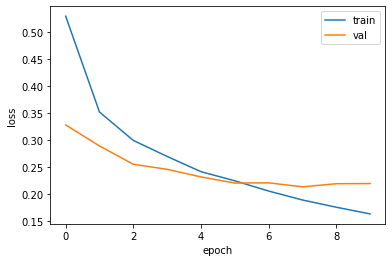

In [7]:
# 손실 그래프 출력
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend(['train', 'val'])

plt.show()

In [8]:
# 최적 파라미터 상태가 지금 model에 저장되어 있음
# 평가
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 5s 13ms/step - loss: 0.2138 - accuracy: 0.9238


[0.21383312344551086, 0.9238333106040955]

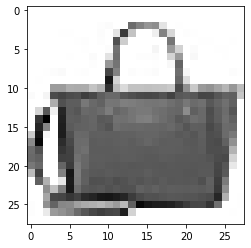

[[4.4457901e-17 9.2692087e-26 8.8876201e-20 8.4015113e-20 3.8676355e-20
  1.9798725e-16 2.8581708e-16 3.1943408e-15 1.0000000e+00 6.0356159e-19]]


In [9]:
# 첫 번째 이미지를 어떻게 predict 하는지 보자
fig, ax = plt.subplots()
ax.imshow(val_scaled[0].reshape(28, 28), cmap='gray_r')
plt.show()
preds = model.predict(val_scaled[0:1]) # [0]라고 하면 안됨
print(preds)

---

predict()에 샘플 이미지 하나만 넣을 때 val_scaled[0]라고 쓰면 안됨

fit(), evaluate(), predict()는 모두 첫 번째 차원을 배치 차원으로 인식함

즉, 28 x 28 x 1 크기의 이미지 한장을 전달한다면

1 x 28 x 28 x 1의 크기로 전달해야 함

그래서 인덱싱을 하면 안되고 슬라이싱을 해야 함

---

In [10]:
# 패션 MNIST의 레이블로 확인해보자
# 패션 MNIST 데이터셋에서 레이블 가져오는 방법 -> https://lazymatlab.tistory.com/155
import tensorflow_datasets as tfds # 코랩 외에서는 설치 필요 (tensorflow와 다른 모듈임)

bldr = tfds.builder('fashion_mnist')
classes = bldr._info().features['label'].names

import numpy as np
print(classes[np.argmax(preds)])

Bag


In [11]:
# 지금까지는 검증세트로만 테스트 했음
# 테스트 세트로도 확인해보자
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0 
model.evaluate(test_scaled, test_target)

313/313 [==============================] - 5s 14ms/step - loss: 0.2360 - accuracy: 0.9146


[0.23600634932518005, 0.9146000146865845]

---

## 8.3 합성곱 신경망의 시각화

---

실제로 신경망이 어떤 식으로 이미지를 필터링 했는지 확인해보자

필터가 어떻게 수렴했는지, 필터링 된 이미지는 어떻게 생겼는지 직접 확인해볼 예정

함수형 API도 알아보겠음

---

In [26]:
from tensorflow import keras

# 마지막으로 저장한 모델 불러오기
model = keras.models.load_model('best-cnn-model.h5')

# 어떻게 생겼는지 보자
model.layers

In [27]:
# 각 레이어의 파라미터는 프로퍼티 weights에 들어있음
# weights[0]은 가중치, weights[1]은 절편
conv = model.layers[0]
conv.weights[0].shape, conv.weights[1].shape

(TensorShape([3, 3, 1, 32]), TensorShape([32]))

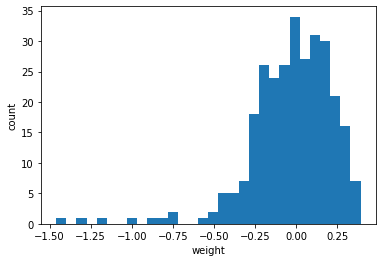

In [14]:
# weights의 각 원소는 TensorShape 객체임
# 자세한 내용은 -> https://codetorial.net/tensorflow/basics_of_tensor.html
# 가중치를 넘파이 배열로 바꾸고 평균, 표준편차를 보자
conv_weights = conv.weights[0].numpy()
conv_weights.mean(), conv_weights.std()

# 히스토그램으로도 그려보자
import matplotlib.pyplot as plt
plt.hist(conv_weights.reshape(-1, 1), bins=30)
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

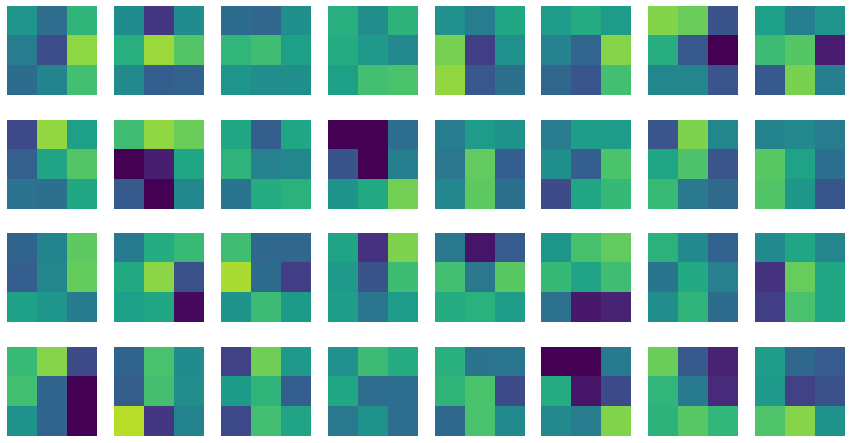

In [15]:
# 필터가 어떻게 생겼는지 보자
fig, ax = plt.subplots(4, 8, figsize=(15, 8))
for i in range(ax.shape[0]):
  for j in range(ax.shape[1]):
    ax[i, j].imshow(conv_weights[:, :, 0, i*ax.shape[1] + j], vmin=-0.5, vmax=0.5)
    ax[i, j].axis('off')

plt.show()

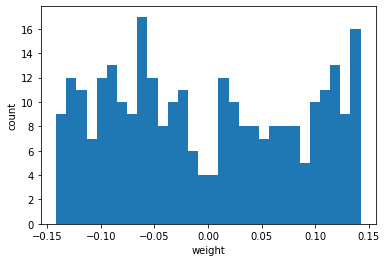

In [16]:
# 이것만 봐서는 왜 필터가 이렇게 만들어졌는지 알 수 없다
# 원래 NN은 이렇게 설명하기 어려운 부분이 있다
# 잘 되는데 왜 잘 되는지 모름
# 대신 훈련을 하지 않은 필터를 보면 차이를 알 수 있음
empty_model = keras.Sequential()
empty_model.add(keras.layers.Conv2D(32,
                                    kernel_size=3, 
                                    activation='relu', 
                                    padding='same',
                                    input_shape=(28, 28, 1)))
empty_model_weights = empty_model.layers[0].weights[0].numpy()

plt.hist(empty_model_weights.reshape(-1, 1), bins=30)
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

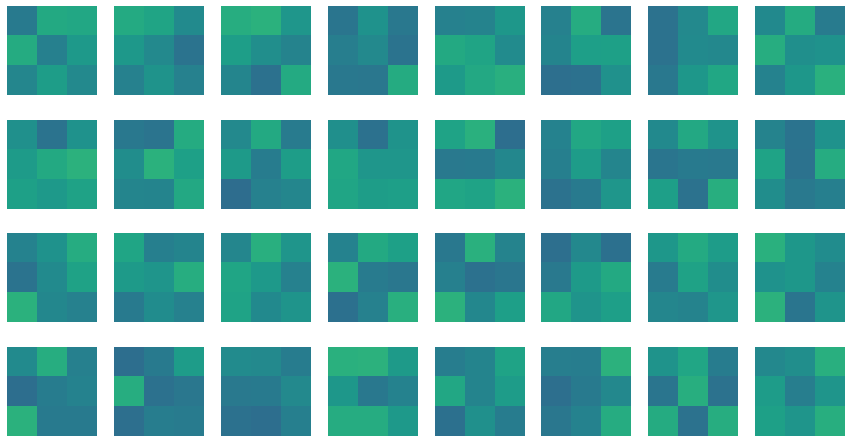

In [17]:
# 필터가 어떻게 생겼는지 보겠음
fig, ax = plt.subplots(4, 8, figsize=(15, 8))
for i in range(ax.shape[0]):
  for j in range(ax.shape[1]):
    ax[i, j].imshow(empty_model_weights[:, :, 0, i*ax.shape[1] + j], vmin=-0.5, vmax=0.5)
    ax[i, j].axis('off')

plt.show()

---

### 함수형 API

---

지금까지 했던 방식은 Sequential()로 빈 신경망을 만들고

거기에 add()로 각 층을 더하는 방식이었음

    dense1 = keras.layers.Dense(100, activation='sigmoid')
    dense2 = keras.layers.Dense(10, activation='softmax')
    model = keras.Sequential()
    model.add(dense1)
    model.add(dense2)
  
이 방식으로는 입력 또는 출력이 2개인 모델을 만들 수 없음

함수형 API를 사용하면 아래처럼 쓸 수 있음

    hidden = dense1(inputs)
    output = dense2(hidden)

inputs를 dense1 층을 통과시켜 hidden을 얻음

hidden을 dense2 층을 통과시켜 output을 얻음

Dense 층을 마치 입력과 출력을 연결짓는 함수처럼 생각할 수 있음

입력층은 따로 만들어줘야 함

    inputs = keras.Input(shape=(784,))

마지막으로 input와 output을 이용하여 모델을 완성시킴

    model = keras.Model(inputs, outputs)

---


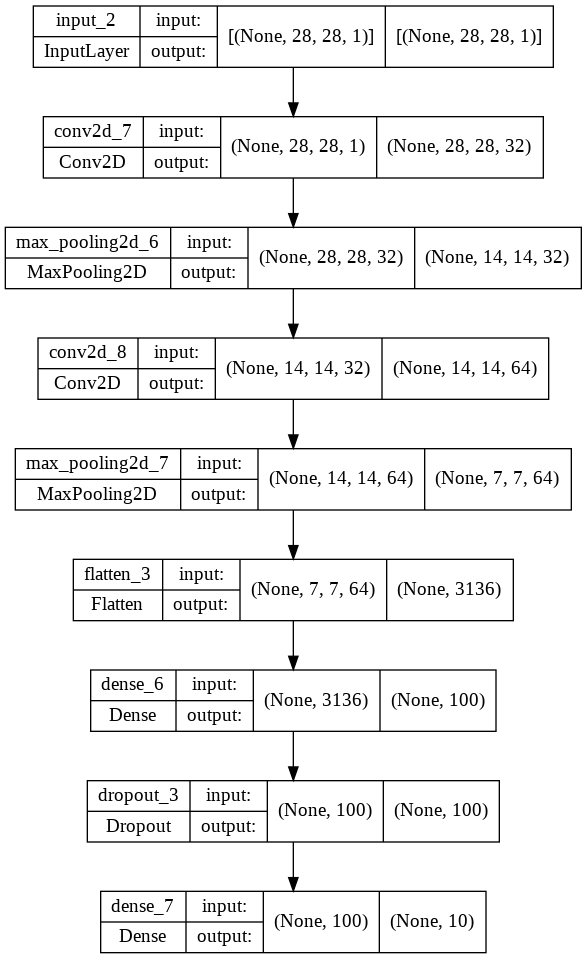

In [30]:
# 함수형 API를 이용한 전체 모델 구성
input = keras.Input(shape=(28, 28, 1))
x = keras.layers.Conv2D(32, 3, activation='relu', padding='same')(input)
x = keras.layers.MaxPooling2D(2)(x)
x = keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = keras.layers.MaxPooling2D(2)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dropout(0.4)(x)
output = keras.layers.Dense(10, activation='softmax')(x)

model_API = keras.Model(input, output)
keras.utils.plot_model(model_API, show_shapes=True)

In [31]:
# Sequential로 만든 모델의 입력층은 Sequential.input에 들어있음
print(model.input)

# 첫번째 합성곱층의 출력을 보고 싶다면
# input와 model.layers[0]을 이용하여 모델을 만들면 됨
conv_acti = keras.Model(model.input, model.layers[0].output)

KerasTensor(type_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='conv2d_input'), name='conv2d_input', description="created by layer 'conv2d_input'")


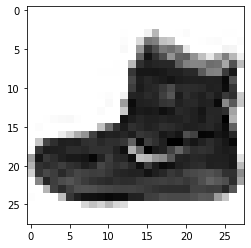

In [19]:
# 패션 MNIST의 첫번째 샘플
(train_input, train_target), (test_input, test_target) = \
    keras.datasets.fashion_mnist.load_data()
plt.imshow(train_input[0], cmap='gray_r')
plt.show()

In [20]:
# 합성곱층의 출력인 특성맵을 저장
inputs = train_input[0:1].reshape(-1, 28, 28, 1) / 255.0
feature_maps = conv_acti.predict(inputs)
feature_maps.shape

(1, 28, 28, 32)

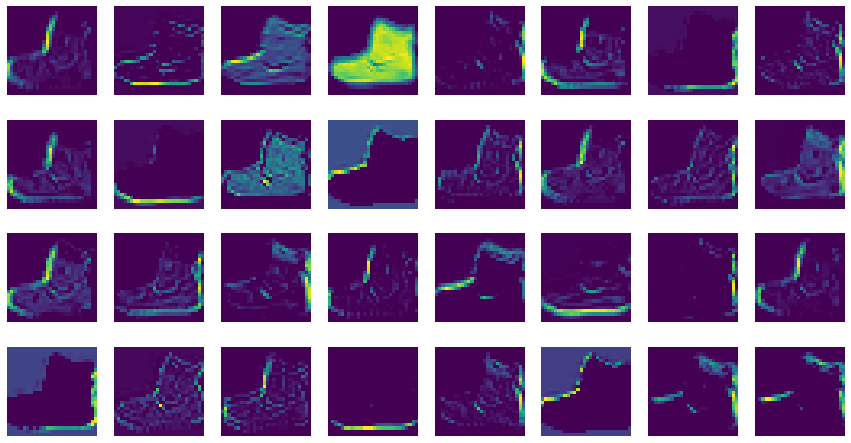

In [21]:
# 특성맵을 이미지로 보자
fig, ax = plt.subplots(4, 8, figsize=(15, 8))
for i in range(ax.shape[0]):
  for j in range(ax.shape[1]):
    ax[i, j].imshow(feature_maps[0, :, :, i*ax.shape[1] + j])
    ax[i, j].axis('off')
plt.show()

In [22]:
# 두 번째 합성곱층이 만드는 특성맵도 보자
conv2_acti = keras.Model(model.input, model.layers[2].output)
input = train_input[0:1].reshape(-1, 28, 28, 1) / 255.0
feature_maps = conv2_acti.predict(inputs)
feature_maps.shape

(1, 14, 14, 64)

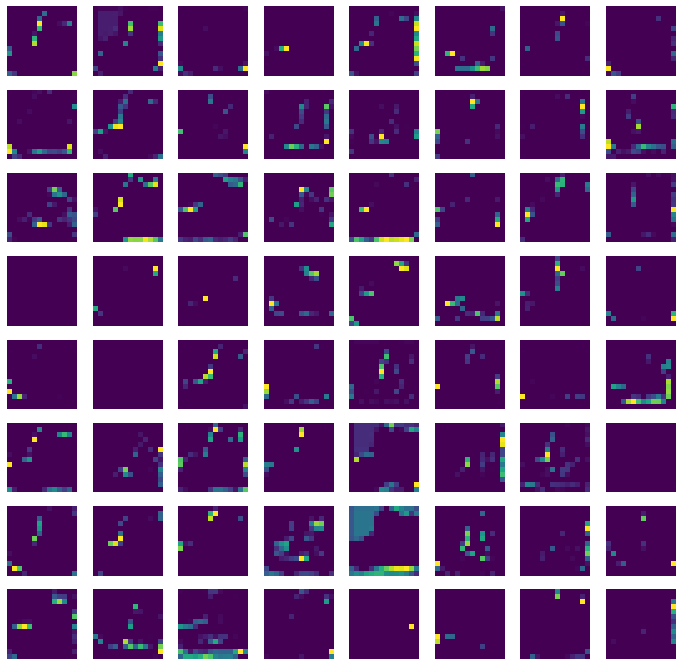

In [23]:
# 특성맵을 이미지로 보자
fig, ax = plt.subplots(8, 8, figsize=(12, 12))
for i in range(ax.shape[0]):
  for j in range(ax.shape[1]):
    ax[i, j].imshow(feature_maps[0, :, :, i*ax.shape[1] + j])
    ax[i, j].axis('off')
plt.show()

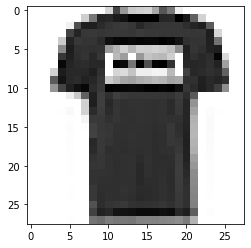

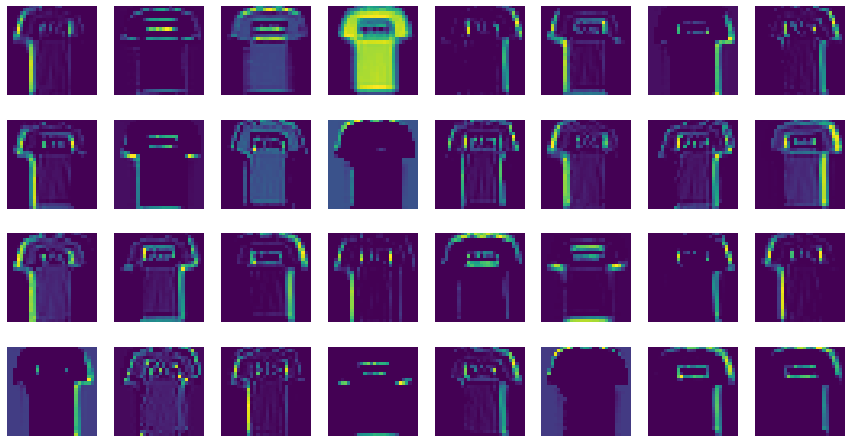

In [24]:
# 패션 MNIST의 첫번째 샘플
plt.imshow(train_input[1], cmap='gray_r')
plt.show()

# 합성곱층의 출력인 특성맵을 저장
inputsaa = train_input[1:2].reshape(-1, 28, 28, 1) / 255.0
feature_mapsaa = conv_acti.predict(inputsaa)

# 특성맵을 이미지로 보자
fig, ax = plt.subplots(4, 8, figsize=(15, 8))
for i in range(ax.shape[0]):
  for j in range(ax.shape[1]):
    ax[i, j].imshow(feature_mapsaa[0, :, :, i*ax.shape[1] + j])
    ax[i, j].axis('off')
plt.show()